Dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
try:
    red = pd.read_csv('/content/drive/MyDrive/IST347/Project/winequality_red.csv')
except:
    red = pd.read_csv('winequality_red.csv')

In [ ]:
try:
    white = pd.read_csv('/content/drive/MyDrive/IST347/Project/winequality_white.csv')
except:
    white = pd.read_csv('winequality_white.csv')

In [ ]:
red_col = red.columns.to_list()
white_col = white.columns.to_list()

### Plot Functions

In [ ]:
def replace_col():
    '''
    Capitalize column names and remove space to '_', except 'pH' 
    '''
    new_red_col = []
    new_white_col = []
    for r, w in zip(red_col, white_col):

        if r =='pH' or w =='pH':
            new_r = r
            new_w = w
        else:
            new_r = r.title().replace(' ','_')
            new_w = w.title().replace(' ','_')

        new_red_col.append(new_r)
        new_white_col.append(new_w)
    red.columns = new_red_col
    white.columns = new_white_col

# replace column name
replace_col()

In [ ]:
def plot_scatter(x_axis,y_axis, h=None):
    '''Plot the scatter plot by input a selected X & Y data'''
    sns.scatterplot(x = x_axis, y = y_axis, hue = h)


In [ ]:
def barplot(xlabel,ylabel,rotate,title):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6), dpi=80)
    ax = sns.barplot(x=xlabel, y=ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, horizontalalignment='right')
    ax.set_title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance Level')
    plt.show()

## Data Understanding

In [ ]:
red.shape

(1599, 12)

In [ ]:
white.shape

(4898, 12)

In [ ]:
red.head()

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
desc = red.describe() # maybe we should consider scaling since max/min for free_Sulfer_Dioxide and Total_Sulfer_dioxide have a drastic difference

In [ ]:
desc

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
red.loc[red.Total_Sulfur_Dioxide>250,'Total_Sulfur_Dioxide'] = red.Total_Sulfur_Dioxide.mean()  #replace outliers with mean
white.loc[(white.Quality ==3) & (white.Total_Sulfur_Dioxide>=300), 'Total_Sulfur_Dioxide'] = white.Total_Sulfur_Dioxide.mean() #replace outliers with mean

Should we consider scaling the df for every algorithm 

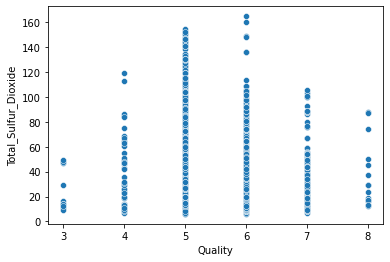

In [ ]:
plot_scatter(red.Quality, red.Total_Sulfur_Dioxide)

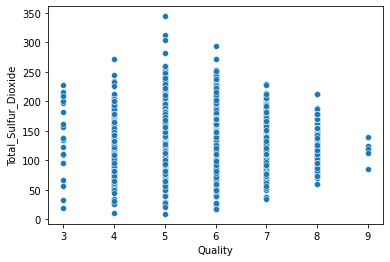

In [ ]:
plot_scatter(white.Quality, white.Total_Sulfur_Dioxide)

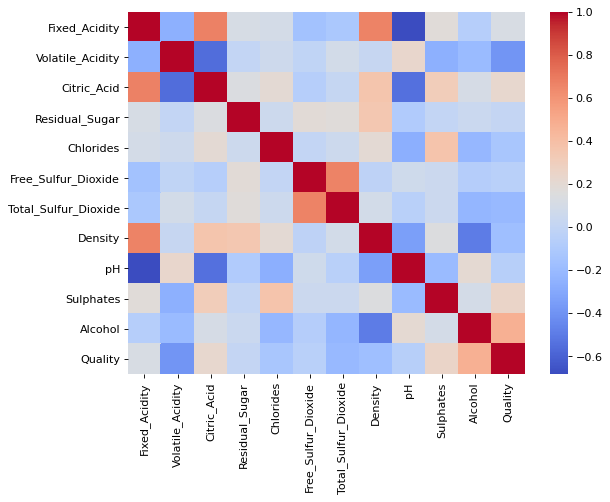

In [ ]:
# red wine correlation heatmap
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(red.corr(), cmap='coolwarm')

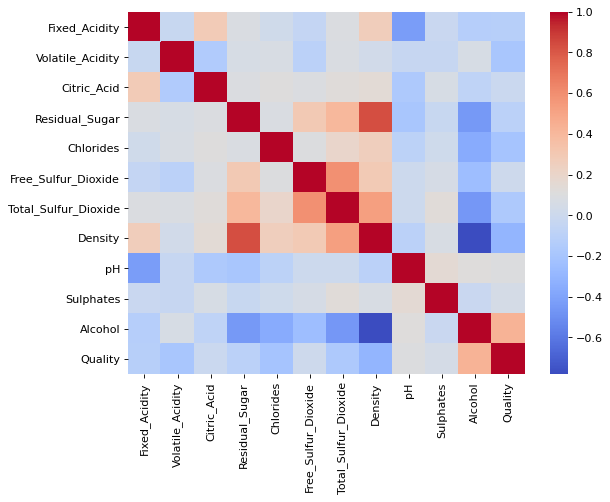

In [ ]:
# white wine correlation heatmap
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(white.corr(), cmap='coolwarm')

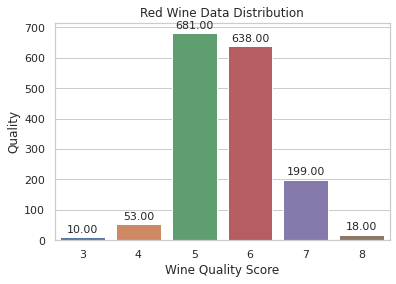

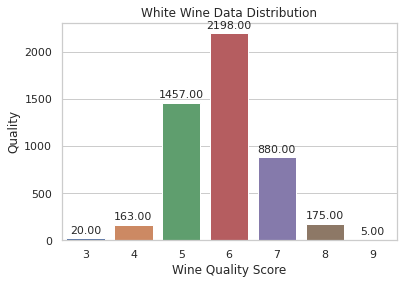

In [ ]:
def distribution():
    red_count = red['Quality'].value_counts()
    rc = red_count.to_frame()
    sns.set_theme(style="whitegrid")
    plots_red= sns.barplot(x = red_count.index, y = red_count)
    plt.xlabel('Wine Quality Score')
    plots_red.set_title('Red Wine Data Distribution')
    for bar in plots_red.patches:
        plots_red.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                    size=11, xytext=(0, 8),
                    textcoords='offset points')
    plt.show()

    white_count = white['Quality'].value_counts()
    wc = white_count.to_frame()
    sns.set_theme(style="whitegrid")
    plots_white= sns.barplot(x = white_count.index, y = white_count)
    plots_white.set_title('White Wine Data Distribution')
    plt.xlabel('Wine Quality Score')
    for bar in plots_white.patches:
        plots_white.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                    size=11, xytext=(0, 8),
                    textcoords='offset points')
distribution()

## Algorithm Functions

### Helper Functions

#### Copy DataFrame

In [ ]:
def copy_df(df):
    '''create a copy of a dataframe and replace quality to two groups for logistic regression use'''
    df_copy = df.copy()
    # print(df_copy)
    df_copy.loc[df_copy.Quality <=5, 'Quality'] = 0 #not good
    df_copy.loc[df_copy.Quality >5, 'Quality'] = 1 #good


    return df_copy

#### Colorful Confusion Matrix

In [ ]:
def plot_colorful_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

### Regression

In [ ]:
# multiple Regerssion
def multi_regression(X_train, X_test, y_train, y_test, error = False):

    '''everything for multiregression is here, call the function and it will 
        automatically run and print out everything'''

    from sklearn.linear_model import LinearRegression

    lm = LinearRegression()
    lm.fit(X_train, y_train)
    #print(f'Intercept is {lm.intercept_}')
    #print()
    #print(f'Cntercept is {lm.coef_}')
    #print()

    y_pred = lm.predict(X_test)
    y_pred_1 = []
    for x in y_pred:
        x = round(x)
        y_pred_1.append(x)
    plt.scatter(y_test, y_pred_1)
    plt.show()
    error = print_errors(y_test, y_pred_1)

    importance = lm.coef_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    return importance

# ridge Regression
def ridge(X_train, X_test, y_train, y_test, alpha=1):
    from sklearn.linear_model import Ridge
    from sklearn import metrics

    error = []
    for x in range(1,50):
        test = []
        test_2 = []
        lm_1 = Ridge(alpha = x)
        lm_1.fit(X_train,y_train)
        y_pred = lm_1.predict(X_test)
        for y in y_pred:
            y = round(y)
            test.append(y)
        r = metrics.mean_absolute_error(y_test,y_pred)
        error.append(r)
    plt.plot(range(1,50), error)
    plt.ylabel('Error')
    plt.xlabel('k value')
    plt.show()
    importance = lm_1.coef_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    alpha_min = error.index(min(error)) + 1
    print(alpha)

    lm_2 = Ridge(alpha = alpha_min)
    lm_2.fit(X_train,y_train)
    y_pred_2 = lm_2.predict(X_test)
    for y in y_pred_2:
            y = round(y)
            test_2.append(y)
    k = metrics.mean_absolute_error(y_test,test_2)
    print_errors(y_test, test_2)

    return importance

# logistic regression
def LR(df,X_train, X_test, y_train, y_test):

    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix

    new_df = copy_df(df)

    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print_confusion_metrics(y_test, y_pred)

    importance = lr.coef_[0]
    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))
     
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    return y_pred

def print_errors(y_test, y_pred):

    '''print all errors by calling this function'''

    from sklearn import metrics
    print(f'Mean Absolute error is: {metrics.mean_absolute_error(y_test, y_pred)}')
    print()
    print(f'Mean Squared error is: {metrics.mean_squared_error(y_test, y_pred)}')
    print()
    print(f'Mean Squared root error is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print()
    print(f'R2 score is : {metrics.r2_score(y_test, y_pred)}')
    print()

### Classification

#### KNN

In [ ]:
def KNN(X_train, X_test, y_train, y_test):

    '''take input and run KNN'''

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    
    #scale dataset
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    #find best K 

    best_k = 0
    accuracy = 0
    scores = []

    for k in range(1,100):
        knn_model = KNeighborsClassifier(n_neighbors = k)
        # print(knn_model)
        knn_model.fit(scaled_X_train, y_train)
        y_pred = knn_model.predict(scaled_X_test)
        score = accuracy_score(y_test, y_pred)
        # print(f'the K right now is {k}, and its score is {score}')
        scores.append(score)

        if score > accuracy:
            best_k = k
            accuracy = score

    print(f'the best K is: {best_k}, and its score is {accuracy}')

    #plot the accuracy
    plt.figure(dpi=100)
    plt.plot(range(1,100), scores, label = 'Accuracy Score')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('k value')
    plt.show()

    #using best_k for KNN

    best_model = KNeighborsClassifier(n_neighbors = best_k)
    best_model.fit(scaled_X_train, y_train)
    y_pred = best_model.predict(scaled_X_test)

    # print()
    # print('-------Confusion Metrics Report-------')
    print(f'Accuracy score of the best k is: {accuracy_score(y_test,y_pred)}')


    plt.scatter(y_test,y_pred)
    plt.title('KNN White Wine Result Comparison')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()


    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='KNN White Wine Confusion matrix')

#### Naive Bayes

In [ ]:
def NB(X_train, X_test, y_train, y_test):
    from sklearn.preprocessing import StandardScaler
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import classification_report, confusion_matrix

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    model = GaussianNB()
    clf = model.fit(scaled_X_train, y_train)
    y_pred = clf.predict(scaled_X_test)
    
    # print_confusion_metrics(y_test, y_pred)

    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='White Wine DT Confusion matrix')

#### Decision Tree

In [ ]:
def DT(X_train, X_test, y_train, y_test, print_tree=None):

    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.tree import plot_tree
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)


    # find the best max_depth 
    accuracy = []
    for k in range(1,100):
        tree_clf = DecisionTreeClassifier(max_depth = k)

        tree_clf.fit(scaled_X_train,y_train)
        y_pred = tree_clf.predict(scaled_X_test)
        acc = accuracy_score(y_test,y_pred)
        accuracy.append(acc)
    acc = accuracy.index(max(accuracy))+1
    

    #Apply best depth to build a model
    tree = DecisionTreeClassifier(max_depth = acc)
    tree.fit(scaled_X_train,y_train)
    y_pred_1 = tree.predict(scaled_X_test)
    
    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred_1))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred_1, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred_1)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='White Wine DT Confusion matrix')
    
    plt.show() 


    try:
        X = red_X
    except:
        X = white_X

    if print_tree == True:
        plt.figure(figsize = (12,8), dpi = 200)
        plot_tree(tree_clf, feature_names = X.columns, filled = True)
    
    # get feature importance
    importance = tree_clf.feature_importances_
    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))

    #plt.bar([x for x in range(len(importance))], importance)
    #plt.show() 

    return importance

#### Random Forest

In [ ]:
def RF(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
    from sklearn.preprocessing import StandardScaler
    

    #scaler = StandardScaler()
    #scaled_X_train = scaler.fit_transform(X_train)
    #scaled_X_test = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=400, max_features = 'log2', random_state = 0)
    model.fit(X_train,y_train)
    y_pred = model.predict(scaled_X_test)
        

    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='DT Confusion matrix')

    plt.show()
    # feature importance
    importance = model.feature_importances_

    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))
     
    # plt.bar([x for x in range(len(importance))], importance)
    # plt.show()

    return importance

## Red Wine

### Split dataset

In [ ]:
# split red wine data
red_X = red.drop(['Quality','Free_Sulfur_Dioxide','Citric_Acid'], axis = 1)
red_y = red.Quality
red_Xtrain,red_Xtest, red_ytrain, red_ytest = train_test_split(red_X,red_y, test_size=0.2, random_state= 101)

### Red Wine Regression

In [ ]:
# Multiregression
# red_a = multi_regression(red_Xtrain,red_Xtest, red_ytrain, red_ytest)
# Ridge regression
# red_b = ridge(red_Xtrain,red_Xtest, red_ytrain, red_ytest)
# Logistic Regression
# LR(red, red_Xtrain,red_Xtest, red_ytrain, red_ytest)

### Red Wine Classification

#### KNN

the best K is: 1, and its score is 0.60625


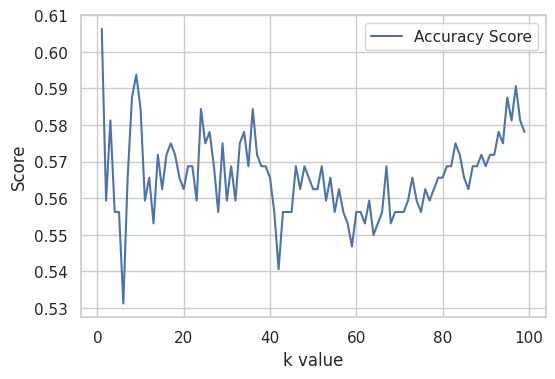

Accuracy score of the best k is: 0.60625


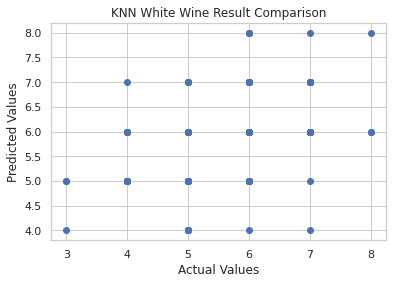

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.71      0.66      0.68       138
           6       0.58      0.66      0.62       122
           7       0.54      0.54      0.54        39
           8       0.20      0.33      0.25         3

    accuracy                           0.61       320
   macro avg       0.34      0.37      0.35       320
weighted avg       0.59      0.61      0.60       320

------Colorful Confusion matrix------


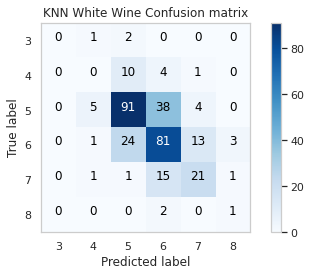

In [ ]:
# KNN
KNN(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

#### Navie Bayes

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.67      0.68      0.67       138
           6       0.52      0.48      0.50       122
           7       0.33      0.41      0.36        39
           8       0.00      0.00      0.00         3

    accuracy                           0.53       320
   macro avg       0.25      0.26      0.26       320
weighted avg       0.52      0.53      0.53       320

------Colorful Confusion matrix------


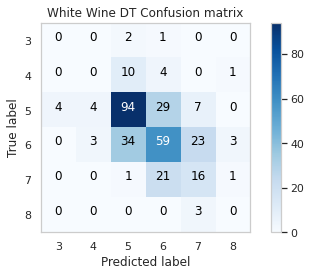

In [ ]:
#Naive Bayes
NB(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

#### Decision Tree

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.50      0.13      0.21        15
           5       0.70      0.67      0.68       138
           6       0.59      0.70      0.64       122
           7       0.44      0.41      0.43        39
           8       0.20      0.33      0.25         3

    accuracy                           0.61       320
   macro avg       0.41      0.37      0.37       320
weighted avg       0.61      0.61      0.60       320

------Colorful Confusion matrix------


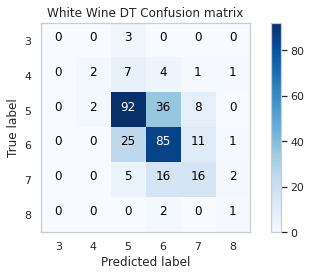

Feature: 0, Score: 0.09827
Feature: 1, Score: 0.13165
Feature: 2, Score: 0.10288
Feature: 3, Score: 0.09787
Feature: 4, Score: 0.11868
Feature: 5, Score: 0.07715
Feature: 6, Score: 0.07109
Feature: 7, Score: 0.14888
Feature: 8, Score: 0.15355


In [ ]:
#Decision Tree, change print tree to True if you want to see the tree!
red_dt_imp = DT(red_Xtrain,red_Xtest, red_ytrain, red_ytest, print_tree=False)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.73      0.74      0.74       138
           6       0.61      0.76      0.68       122
           7       0.62      0.38      0.48        39
           8       0.33      0.33      0.33         3

    accuracy                           0.66       320
   macro avg       0.38      0.37      0.37       320
weighted avg       0.63      0.66      0.64       320

------Colorful Confusion matrix------


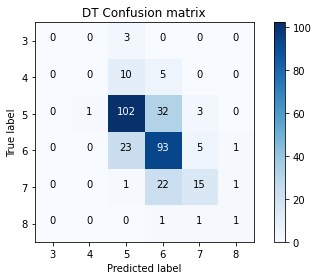

Feature: 0, Score: 0.09204
Feature: 1, Score: 0.12531
Feature: 2, Score: 0.07904
Feature: 3, Score: 0.09733
Feature: 4, Score: 0.12519
Feature: 5, Score: 0.10373
Feature: 6, Score: 0.08693
Feature: 7, Score: 0.12872
Feature: 8, Score: 0.16173


In [ ]:
# Random Forest
red_rf_imp = RF(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

## White Wine

### Split dataset

In [ ]:
# split white wine data
white_X = white.drop(['Quality','Residual_Sugar'], axis = 1)
white_y = white.Quality
white_Xtrain,white_Xtest, white_ytrain, white_ytest = train_test_split(white_X,white_y, test_size=0.2, random_state=101)

### White Wine Regression

In [ ]:
# Multiregression
# white_a = multi_regression(white_Xtrain,white_Xtest, white_ytrain, white_ytest)
# Ridge Regression
# white_b = ridge(white_Xtrain,white_Xtest, white_ytrain, white_ytest)
# Logistic Regression
# white_c = LR(white, white_Xtrain,white_Xtest, white_ytrain, white_ytest)

### White Wine Classification

#### KNN

the best K is: 1, and its score is 0.6408163265306123


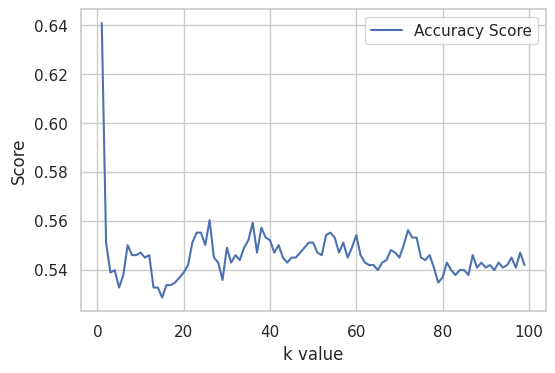

Accuracy score of the best k is: 0.6408163265306123


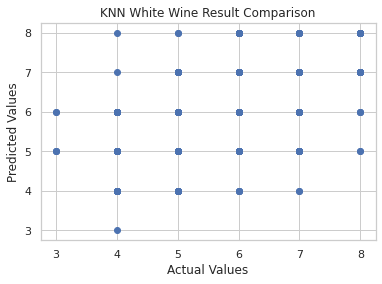

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.42      0.24      0.31        41
           5       0.64      0.64      0.64       306
           6       0.69      0.68      0.69       433
           7       0.60      0.66      0.63       158
           8       0.51      0.54      0.53        37

    accuracy                           0.64       980
   macro avg       0.47      0.46      0.46       980
weighted avg       0.64      0.64      0.64       980

------Colorful Confusion matrix------


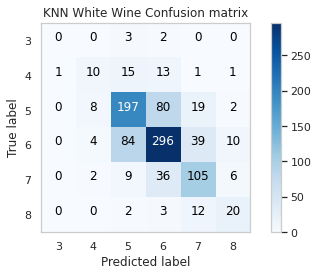

In [ ]:
#KNN
KNN(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

#### Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           3       0.08      0.20      0.11         5
           4       0.21      0.17      0.19        41
           5       0.54      0.57      0.56       306
           6       0.55      0.36      0.44       433
           7       0.34      0.68      0.46       158
           8       0.17      0.03      0.05        37

    accuracy                           0.46       980
   macro avg       0.31      0.34      0.30       980
weighted avg       0.48      0.46      0.45       980

------Colorful Confusion matrix------


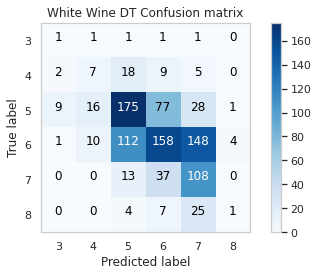

In [ ]:
#Naive Bayes
NB(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

#### Decision Tree

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.28      0.27      0.27        41
           5       0.64      0.64      0.64       306
           6       0.65      0.63      0.64       433
           7       0.51      0.54      0.53       158
           8       0.38      0.41      0.39        37
           9       0.00      0.00      0.00         0

    accuracy                           0.59       980
   macro avg       0.35      0.36      0.35       980
weighted avg       0.59      0.59      0.59       980

------Colorful Confusion matrix------


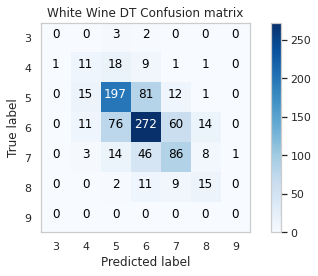

Feature: 0, Score: 0.07457
Feature: 1, Score: 0.10958
Feature: 2, Score: 0.08968
Feature: 3, Score: 0.08437
Feature: 4, Score: 0.09879
Feature: 5, Score: 0.09576
Feature: 6, Score: 0.10181
Feature: 7, Score: 0.10689
Feature: 8, Score: 0.08369
Feature: 9, Score: 0.15487


In [ ]:
#Decision Tree, change print tree to True if you want to see the tree!
white_dt_imp = DT(white_Xtrain,white_Xtest, white_ytrain, white_ytest, print_tree=False)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.70      0.17      0.27        41
           5       0.71      0.70      0.70       306
           6       0.66      0.78      0.72       433
           7       0.68      0.58      0.63       158
           8       0.83      0.41      0.55        37

    accuracy                           0.68       980
   macro avg       0.60      0.44      0.48       980
weighted avg       0.68      0.68      0.67       980

------Colorful Confusion matrix------


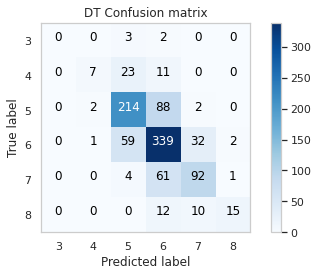

Feature: 0, Score: 0.08384
Feature: 1, Score: 0.10524
Feature: 2, Score: 0.08997
Feature: 3, Score: 0.09029
Feature: 4, Score: 0.10437
Feature: 5, Score: 0.10059
Feature: 6, Score: 0.11536
Feature: 7, Score: 0.09590
Feature: 8, Score: 0.08782
Feature: 9, Score: 0.12662


In [ ]:
# Random Forest
white_rf_imp = RF(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

## Feature Importance

### Red Wine

#### Decision Tree

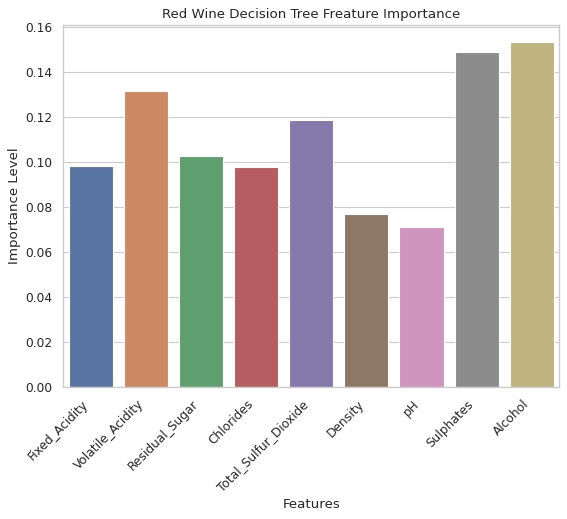

In [ ]:
# Red Decision Tree
barplot(red_X.columns, red_dt_imp, 45, 'Red Wine Decision Tree Freature Importance')

#### Random Forest

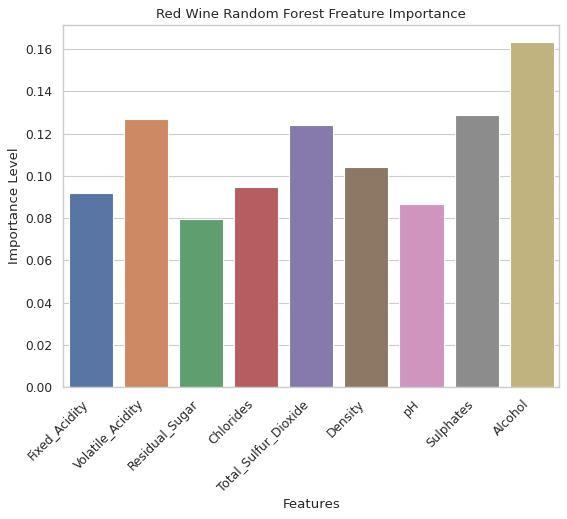

In [ ]:
# Red Random Forest
barplot(red_X.columns, red_rf_imp, 45, 'Red Wine Random Forest Freature Importance')

#### Line Charts

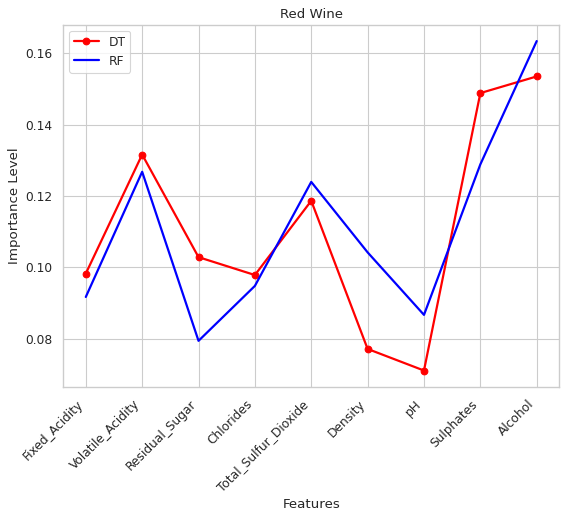

In [ ]:
# Red Wine Line Charts
plt.figure(figsize=(8, 6), dpi=80)
plt.plot( red_X.columns, red_dt_imp, marker='o', color='red', linewidth=2)
plt.plot( red_X.columns, red_rf_imp, marker='', color='blue', linewidth=2)
plt.xticks(rotation = 45,horizontalalignment="right") 
plt.title('Red Wine')
plt.xlabel('Features')
plt.ylabel('Importance Level')
plt.legend(['DT', 'RF'])
plt.show()

### White Wine

#### Decision Tree

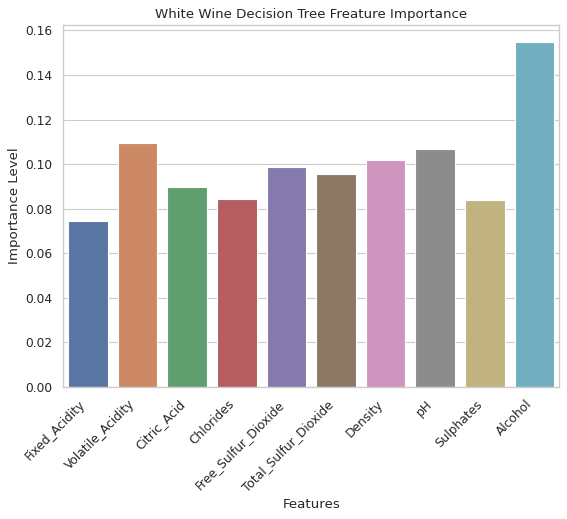

In [ ]:
barplot(white_X.columns, white_dt_imp,45, 'White Wine Decision Tree Freature Importance')

#### Random Forest

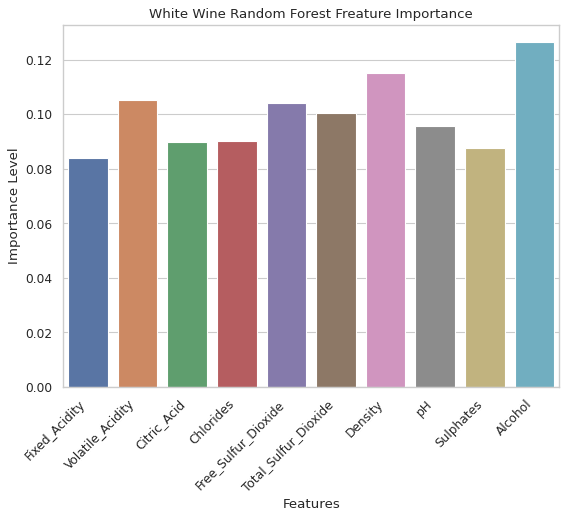

In [ ]:
barplot(white_X.columns, white_rf_imp,45, 'White Wine Random Forest Freature Importance')

#### Line Charts

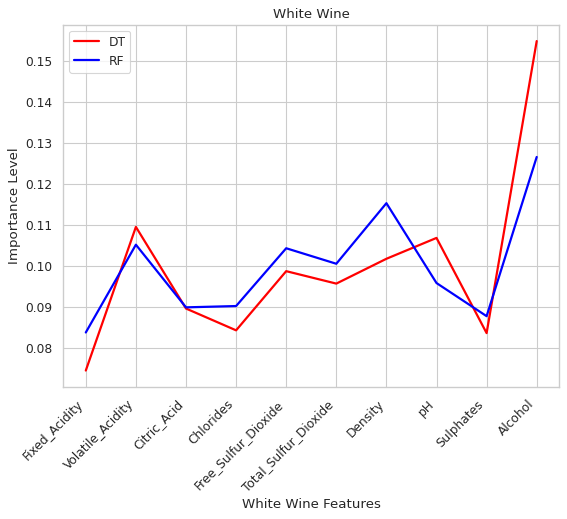

In [ ]:
# White Wine Line Charts
plt.figure(figsize=(8, 6), dpi=80)
plt.plot( white_X.columns, white_dt_imp, marker='', color='red', linewidth=2)
plt.plot( white_X.columns, white_rf_imp, marker='', color='blue', linewidth=2)
plt.xticks(rotation = 45,horizontalalignment="right")
plt.title('White Wine') 
plt.xlabel('White Wine Features')
plt.ylabel('Importance Level')
plt.legend(['DT', 'RF'])
plt.show()

In [ ]:
def compare_good_bad(df):
    good = df.loc[df['Quality'] >=7]
    bad = df.loc[df['Quality']< 7]
    good_df = good.describe().loc['mean', 'Fixed_Acidity': 'Alcohol'].to_frame().transpose()
    bad_df = bad.describe().loc['mean', 'Fixed_Acidity': 'Alcohol'].to_frame().transpose()
    good_df['Good/Bad'] = 'Good (Quality >= 7)'
    bad_df['Good/Bad'] = 'Bad (Quality < 7)'
    all_df = pd.concat([good_df, bad_df])
    return all_df

In [ ]:
compare_good_bad(red)

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Good/Bad
mean,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,32.704772,0.996030,3.288802,0.743456,11.518049,Good (Quality >= 7)
mean,8.236831,0.547022,0.254407,2.512120,0.089281,16.172214,48.285818,0.996859,3.314616,0.644754,10.251037,Bad (Quality < 7)


In [ ]:
compare_good_bad(white)

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Good/Bad
mean,6.725142,0.265349,0.326057,5.261509,0.038160,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022,Good (Quality >= 7)
mean,6.890594,0.281802,0.336438,6.703478,0.047875,35.517327,141.800829,0.994474,3.180847,0.487004,10.265215,Bad (Quality < 7)
